In [ ]:
!python /home/harinarayan/pickup_and_delivery/Capacitated_PDP_Updated_Code/run.py --graph_size 6 --baseline rollout --run_name 'PDP20_rollout'

{'baseline': 'rollout',
 'batch_size': 512,
 'bl_alpha': 0.05,
 'bl_warmup_epochs': 1,
 'checkpoint_encoder': False,
 'checkpoint_epochs': 1,
 'data_distribution': None,
 'embedding_dim': 128,
 'epoch_size': 1280000,
 'epoch_start': 0,
 'eval_batch_size': 1024,
 'eval_only': False,
 'exp_beta': 0.8,
 'graph_size': 6,
 'hidden_dim': 128,
 'load_path': None,
 'log_dir': 'logs',
 'log_step': 50,
 'lr_critic': 0.0001,
 'lr_decay': 1.0,
 'lr_model': 0.0001,
 'max_grad_norm': 1.0,
 'model': 'attention',
 'n_encode_layers': 3,
 'n_epochs': 800,
 'no_cuda': False,
 'no_progress_bar': False,
 'no_tensorboard': False,
 'normalization': 'batch',
 'output_dir': 'outputs',
 'problem': 'pdp',
 'resume': None,
 'run_name': 'PDP20_rollout_20220825T010813',
 'save_dir': 'outputs/pdp_6/PDP20_rollout_20220825T010813',
 'seed': 1234,
 'shrink_size': None,
 'tanh_clipping': 10.0,
 'use_cuda': True,
 'val_dataset': None,
 'val_size': 10000}
Evaluating baseline model on evaluation dataset
100%|██████████████

 78%|██████████████████████████████▍        | 1950/2500 [02:30<00:45, 12.11it/s]epoch: 0, train_batch_id: 1950, avg_cost: 2.7395248413085938
grad_norm: 2.0854568481445312, clipped: 1.0
 80%|███████████████████████████████▏       | 2000/2500 [02:34<00:38, 12.87it/s]epoch: 0, train_batch_id: 2000, avg_cost: 2.7241694927215576
grad_norm: 1.74665105342865, clipped: 1.0
 82%|███████████████████████████████▉       | 2050/2500 [02:37<00:30, 14.78it/s]epoch: 0, train_batch_id: 2050, avg_cost: 2.7302026748657227
grad_norm: 1.8480806350708008, clipped: 1.0
 84%|████████████████████████████████▊      | 2100/2500 [02:41<00:27, 14.45it/s]epoch: 0, train_batch_id: 2100, avg_cost: 2.75022029876709
grad_norm: 1.8128546476364136, clipped: 1.0
 86%|█████████████████████████████████▌     | 2150/2500 [02:44<00:24, 14.49it/s]epoch: 0, train_batch_id: 2150, avg_cost: 2.75413179397583
grad_norm: 2.5011556148529053, clipped: 1.0
 88%|██████████████████████████████████▎    | 2200/2500 [02:48<00:20, 14.49it/s]e

In [ ]:
#Plotting the results


In [ ]:
import os
import numpy as np
import torch

import sys
sys.path.append('/content/Heterogeneous-Attentions-PDP-DRL')

from torch.utils.data import DataLoader
from utils import load_model
from problems import PDP_cap

from nets.attention_model import AttentionModel

from utils.functions import parse_softmax_temperature, torch_load_cpu, _load_model_file


In [ ]:
def load_model(path):
    model_filename = path
    problem = PDP_cap()
    model = AttentionModel(
        embedding_dim=128,
        hidden_dim=128,
        problem=problem,
        n_encode_layers=3,
        mask_inner=True,
        mask_logits=True,
        normalization='batch',
        tanh_clipping=8,
        checkpoint_encoder=False,
        shrink_size=None
    )
    # Overwrite model parameters by parameters to load
    load_data = torch_load_cpu(model_filename)
    model.load_state_dict({**model.state_dict(), **load_data.get('model', {})})

    model, *_ = _load_model_file(model_filename, model)

    model.eval()  # Put in eval mode

    return model, None

In [ ]:
#Plotting functions

%matplotlib inline
from matplotlib import pyplot as plt

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# Code inspired by Google OR Tools plot:
# https://github.com/google/or-tools/blob/fb12c5ded7423d524fc6c95656a9bdc290a81d4d/examples/python/cvrptw_plot.py

def discrete_cmap(N, base_cmap=None):
  """
    Create an N-bin discrete colormap from the specified input map
    """
  # Note that if base_cmap is a string or None, you can simply do
  #    return plt.cm.get_cmap(base_cmap, N)
  # The following works for string, None, or a colormap instance:

  base = plt.cm.get_cmap(base_cmap)
  color_list = base(np.linspace(0, 1, N))
  cmap_name = base.name + str(N)
  return base.from_list(cmap_name, color_list, N)

def plot_vehicle_routes(data, route, ax1, markersize=5, visualize_demands=True, demand_scale=1, round_demand=False):
    """
    Plot the vehicle routes on matplotlib axis ax1.
    """
    
    # route is one sequence, separating different routes with 0 (depot)
    routes = [r[r!=0] for r in np.split(route.cpu().numpy(), np.where(route==0)[0]) if (r != 0).any()]
    depot = data['depot'].cpu().numpy()
    locs = data['loc'].cpu().numpy()
    demands = data['demand'].cpu().numpy() * demand_scale
    capacity = demand_scale # Capacity is always 1
    
    x_dep, y_dep = depot
    ax1.plot(x_dep, y_dep, 'sk', markersize=markersize*4)
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    
    legend = ax1.legend(loc='upper center')
    
    cmap = discrete_cmap(len(routes) + 2, 'nipy_spectral')
    dem_rects = []
    used_rects = []
    cap_rects = []
    qvs = []
    total_dist = 0
    for veh_number, r in enumerate(routes):
        color = cmap(len(routes) - veh_number) # Invert to have in rainbow order
        
        route_demands = demands[r - 1]
        coords = locs[r - 1, :]
        xs, ys = coords.transpose()

        total_route_demand = sum(route_demands)
        assert total_route_demand <= capacity
        if not visualize_demands:
            ax1.plot(xs, ys, 'o', mfc=color, markersize=markersize, markeredgewidth=0.0)
        
        dist = 0
        x_prev, y_prev = x_dep, y_dep
        cum_demand = 0
        i=0
        for (x, y), d in zip(coords, route_demands):
            dist += np.sqrt((x - x_prev) ** 2 + (y - y_prev) ** 2)
            
            
            cap_rects.append(Rectangle((x, y), 0.01, 0.1))
            used_rects.append(Rectangle((x, y), 0.01, 0.1 * total_route_demand / capacity))
            dem_rects.append(Rectangle((x, y + 0.1 * cum_demand / capacity), 0.01, 0.1 * d / capacity))
            if d < 0:
              plt.text(x,y,(f"d{int(r[i]-(len(r)/2))}",round(d,2)) )
            else:
              plt.text(x,y,(f"p{r[i]}",round(d,2)) )
            i +=1


            x_prev, y_prev = x, y
            cum_demand += d
            
        dist += np.sqrt((x_dep - x_prev) ** 2 + (y_dep - y_prev) ** 2)
        total_dist += dist
        qv = ax1.quiver(
            xs[:-1],
            ys[:-1],
            xs[1:] - xs[:-1],
            ys[1:] - ys[:-1],
            scale_units='xy',
            angles='xy',
            scale=1,
            color=color,
            label='R{}, # {}, c {} / {}, d {:.2f}'.format(
                veh_number, 
                len(r), 
                int(total_route_demand) if round_demand else total_route_demand, 
                int(capacity) if round_demand else capacity,
                dist
            )
        )
        
        qvs.append(qv)
        
    ax1.set_title('{} routes, total distance {:.2f}'.format(len(routes), total_dist))
    ax1.legend(handles=qvs)
    
    pc_cap = PatchCollection(cap_rects, facecolor='whitesmoke', alpha=1.0, edgecolor='lightgray')
    pc_used = PatchCollection(used_rects, facecolor='green', alpha=1.0, edgecolor='lightgray')
    pc_dem = PatchCollection(dem_rects, facecolor='black', alpha=1.0, edgecolor='black')
    
    if visualize_demands:
        ax1.add_collection(pc_cap)
        ax1.add_collection(pc_used)
        ax1.add_collection(pc_dem)

In [ ]:
#Making a capacitated PDP Dataset
from torch.utils.data import Dataset
class PDP_cap_Dataset(Dataset):

    def __init__(self, filename=None, size=50, num_samples=1000000, offset=0, distribution=None):
        super(PDP_cap_Dataset, self).__init__()

        self.data_set = []
        if filename is not None:
            assert os.path.splitext(filename)[1] == '.pkl'

            with open(filename, 'rb') as f:
                data = pickle.load(f)
            self.data = [make_instance(args) for args in data[offset:offset+num_samples]]

        else:

              # # From VRP with RL paper https://arxiv.org/abs/1802.04240
              # CAPACITIES = {
              #     10: 20.,
              #     20: 30.,
              #     50: 40.,
              #     100: 50.
              # }         #For adjusting the average number of orders that can be loaded on the resource at a time

            #Any information required for the vehicle capacity?
            #Should interim_demand be accessible as a class attribute?
            #If needed, the vehicle could carry all of them at once.
            interim_demand = (torch.FloatTensor(size//2).uniform_(0, 1))
            self.data = [
                {
                    # Why not across [-1, 1]?
                    #'loc' refers to the initial location of the resource
                    'loc': torch.FloatTensor(size, 2).uniform_(0, 1),
                    'depot': torch.FloatTensor(2).uniform_(0, 1),
                    #Vehicle capacity shall be 1 and demands in Uniform (0, 1)
                    #Interaction between number of nodes, size range of each node, resource capacity to load 
                          #ratio etc
                    #---Demand of second-half should be negative of the first half
                    'demand': torch.cat((interim_demand, torch.neg(interim_demand)), -1 )    #Setting avg number of loadable orders at a time
                }
                for i in range(num_samples)
            ]

        self.size = len(self.data)

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
pdp_cap_make_dataset= PDP_cap_Dataset(size=10, num_samples=1)

In [ ]:
model_path = '/content/outputs/pdp_10/PDP_cap_10_rollout_20220617T065812/epoch-11.pt'
at_model, _ = load_model(model_path)

  [*] Loading model from /content/outputs/pdp_10/PDP_cap_10_rollout_20220617T065812/epoch-11.pt


In [ ]:
# Need a dataloader to batch instances
dataloader = DataLoader(pdp_cap_make_dataset, batch_size=1)

# Make var works for dicts
batch = next(iter(dataloader))

# Run the model
at_model.eval()
at_model.set_decode_type('greedy')
with torch.no_grad():
    length, log_p, pi = at_model(batch, return_pi=True)
tours = pi

No handles with labels found to put in legend.


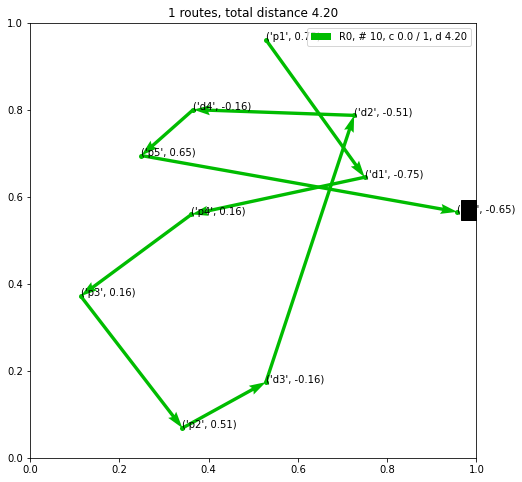

In [ ]:
# Epoch-11 
# Plot the results
for i, (data, tour) in enumerate(zip(pdp_cap_make_dataset, tours)):
    fig, ax = plt.subplots(figsize=(8, 8))
    plot_vehicle_routes(data, tour, ax, visualize_demands=False, demand_scale=1, round_demand=False)
    #fig.savefig(os.path.join('images', 'pdp_cap_{}.png'.format(i)))

No handles with labels found to put in legend.


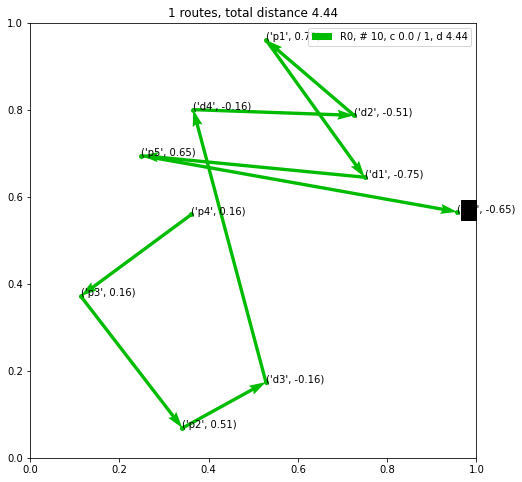

In [ ]:
# Epoch-10 
# Plot the results
for i, (data, tour) in enumerate(zip(pdp_cap_make_dataset, tours)):
    fig, ax = plt.subplots(figsize=(8, 8))
    plot_vehicle_routes(data, tour, ax, visualize_demands=False, demand_scale=1, round_demand=False)
    #fig.savefig(os.path.join('images', 'pdp_cap_{}.png'.format(i)))

No handles with labels found to put in legend.


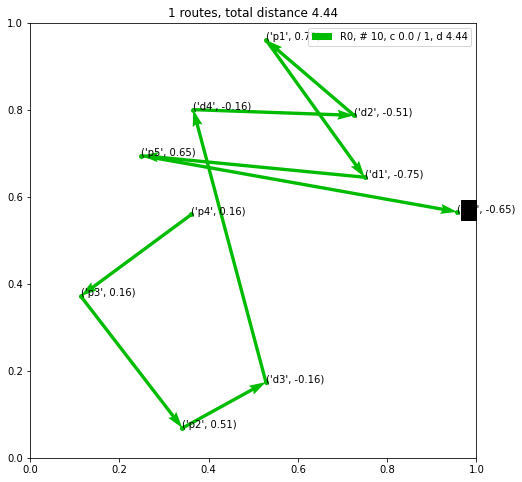

In [ ]:
# Epoch-0 
# Plot the results
for i, (data, tour) in enumerate(zip(pdp_cap_make_dataset, tours)):
    fig, ax = plt.subplots(figsize=(8, 8))
    plot_vehicle_routes(data, tour, ax, visualize_demands=False, demand_scale=1, round_demand=False)
    #fig.savefig(os.path.join('images', 'pdp_cap_{}.png'.format(i)))

No handles with labels found to put in legend.


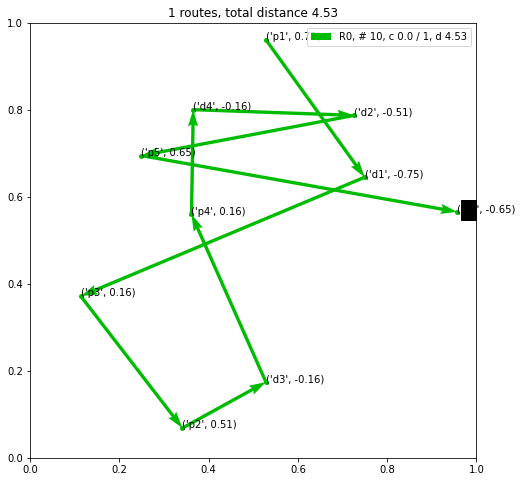

In [ ]:
# Epoch-16 
# Plot the results
for i, (data, tour) in enumerate(zip(pdp_cap_make_dataset, tours)):
    fig, ax = plt.subplots(figsize=(8, 8))
    plot_vehicle_routes(data, tour, ax, visualize_demands=False, demand_scale=1, round_demand=False)
    #fig.savefig(os.path.join('images', 'pdp_cap_{}.png'.format(i)))

No handles with labels found to put in legend.


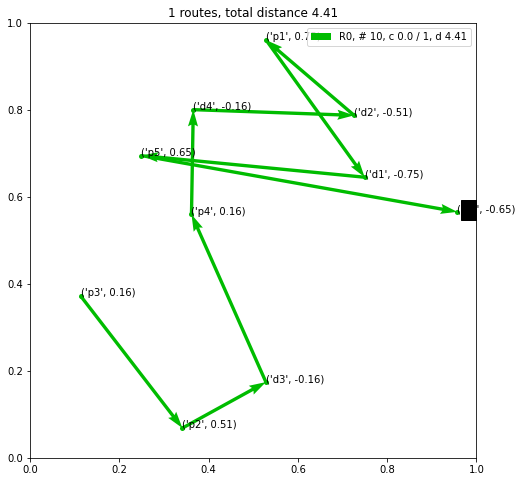

In [ ]:
# Epoch-18 (same for 17) worse! than 14
# Plot the results
for i, (data, tour) in enumerate(zip(pdp_cap_make_dataset, tours)):
    fig, ax = plt.subplots(figsize=(8, 8))
    plot_vehicle_routes(data, tour, ax, visualize_demands=False, demand_scale=1, round_demand=False)
    #fig.savefig(os.path.join('images', 'pdp_cap_{}.png'.format(i)))

No handles with labels found to put in legend.


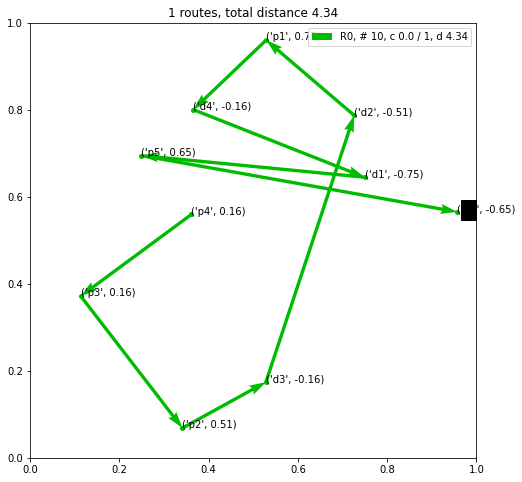

In [ ]:
#Epoch-14
# Plot the results
for i, (data, tour) in enumerate(zip(pdp_cap_make_dataset, tours)):
    fig, ax = plt.subplots(figsize=(8, 8))
    plot_vehicle_routes(data, tour, ax, visualize_demands=False, demand_scale=1, round_demand=False)
    #fig.savefig(os.path.join('images', 'pdp_cap_{}.png'.format(i)))

No handles with labels found to put in legend.


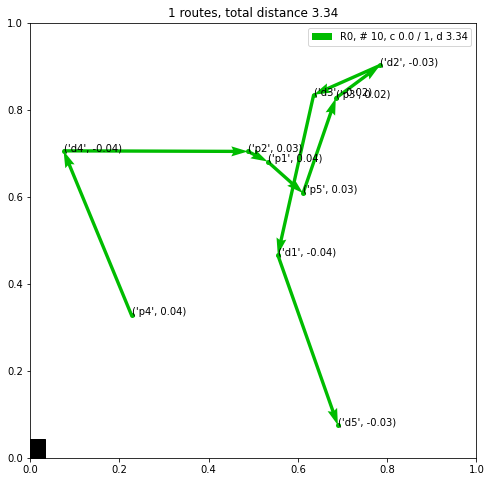

In [ ]:
# Plot the results
for i, (data, tour) in enumerate(zip(pdp_cap_make_dataset, tours)):
    fig, ax = plt.subplots(figsize=(8, 8))
    plot_vehicle_routes(data, tour, ax, visualize_demands=False, demand_scale=1, round_demand=False)
    # fig.savefig(os.path.join('images', 'cvrp_{}.png'.format(i)))

In [ ]:
pdp_cap_make_dataset[0]['demand']

tensor([ 0.0354,  0.0309,  0.0242,  0.0431,  0.0279, -0.0354, -0.0309, -0.0242,
        -0.0431, -0.0279])

In [ ]:
tours[0]

tensor([ 0,  4,  9,  2,  1,  5,  3,  7,  8,  6, 10])

In [ ]:
model, _ = load_model('pretrained/cvrp_100/')
torch.manual_seed(1234)
dataset = CVRP.make_dataset(size=100, num_samples=10)

In [ ]:
import torch

In [ ]:
graph_size = 20 #Total number of nodes excluding the depot in each graph
batch_size = 512  #Number of graphs to be sent together for \
                  #one optimisation cycle (cumulative gradient will\
                  # be computed across 512 graphs)
num_batch_per_epoch = 2500
num_samples = num_batch_per_epoch*batch_size
                        # total number of graphs created for each\
                        # epoch, after each epoch baseline\
                        # might be updated

#This is the entire dataset for a single epoch , containing #num_samples of graphs , each graph having 
      # graph_size nodes/ location (which will be further split into 10 pickup and 10 drop locations - 10 orders)
      # plus one node for depot
      # n order => graph_size = 2*n
#This process is repeated / "entirely new datasets" for each epoch
#One graph is only used once while training

In [ ]:
#Some features that need to be added:
# - multiple orders at same node. 

In [ ]:
#Making a capacitated PDP Dataset
from torch.utils.data import Dataset
class PDP_cap_Dataset(Dataset):

    def __init__(self, filename=None, size=50, num_samples=1000000, offset=0, distribution=None):
        super(PDP_cap_Dataset, self).__init__()

        self.data_set = []
        if filename is not None:
            assert os.path.splitext(filename)[1] == '.pkl'

            with open(filename, 'rb') as f:
                data = pickle.load(f)
            self.data = [make_instance(args) for args in data[offset:offset+num_samples]]

        else:

              # # From VRP with RL paper https://arxiv.org/abs/1802.04240
              # CAPACITIES = {
              #     10: 20.,
              #     20: 30.,
              #     50: 40.,
              #     100: 50.
              # }         #For adjusting the average number of orders that can be loaded on the resource at a time

            #Any information required for the vehicle capacity?
            #Should interim_demand be accessible as a class attribute?
            #If needed, the vehicle could carry all of them at once.
            interim_demand = (torch.FloatTensor(size//2).uniform_(0, 1))
            self.data = [
                {
                    # Why not across [-1, 1]?
                    #'loc' refers to the initial location of the resource
                    'loc': torch.FloatTensor([[0.1, 0.1], [0.1, 0.1],\
                                              [0.5, 0.1], [0.9, 0.9],\
                                              [0.2, 0.2], [0.1, 0.1],\
                                              [0.75, 0.6], [0.8, 0.8],\
                                              [0.45, 0.45], [0.7, 0.7]
                                              ]),
                    'depot': torch.FloatTensor([0.1, 0.1]),
                    #Vehicle capacity shall be 1 and demands in Uniform (0, 1)
                    #Interaction between number of nodes, size range of each node, resource capacity to load 
                          #ratio etc
                    #---Demand of second-half should be negative of the first half
                    'demand': torch.cat((interim_demand, torch.neg(interim_demand)), -1 )    #Setting avg number of loadable orders at a time
                }
                for i in range(num_samples)
            ]

        self.size = len(self.data)

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
#Making a capacitated PDP Dataset
from torch.utils.data import Dataset
class PDP_cap_Dataset(Dataset):

    def __init__(self, filename=None, size=50, num_samples=1000000, offset=0, distribution=None):
        super(PDP_cap_Dataset, self).__init__()

        self.data_set = []
        if filename is not None:
            assert os.path.splitext(filename)[1] == '.pkl'

            with open(filename, 'rb') as f:
                data = pickle.load(f)
            self.data = [make_instance(args) for args in data[offset:offset+num_samples]]

        else:

              # # From VRP with RL paper https://arxiv.org/abs/1802.04240
              # CAPACITIES = {
              #     10: 20.,
              #     20: 30.,
              #     50: 40.,
              #     100: 50.
              # }         #For adjusting the average number of orders that can be loaded on the resource at a time

            #Any information required for the vehicle capacity?
            #Should interim_demand be accessible as a class attribute?
            #If needed, the vehicle could carry all of them at once.
            interim_demand = (torch.FloatTensor(size//2).uniform_(0, 1))/size/2
            self.data = [
                {
                    # Why not across [-1, 1]?
                    #'loc' refers to the initial location of the resource
                    'loc': torch.FloatTensor(size, 2).uniform_(0, 1),
                    'depot': torch.FloatTensor(2).uniform_(0, 1),
                    #Vehicle capacity shall be 1 and demands in Uniform (0, 1)
                    #Interaction between number of nodes, size range of each node, resource capacity to load 
                          #ratio etc
                    #---Demand of second-half should be negative of the first half
                    'demand': torch.cat((interim_demand, torch.neg(interim_demand)), -1 )    #Setting avg number of loadable orders at a time
                }
                for i in range(num_samples)
            ]

        self.size = len(self.data)

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
pdp_cap_make_dataset= PDP_cap_Dataset(size=graph_size, num_samples=num_samples)

In [ ]:
len(pdp_cap_make_dataset)

1280000

In [ ]:
len(pdp_cap_make_dataset[0]['loc'])

20

In [ ]:
# the exact need for clubbing together the baseline score and dataset
class BaselineDataset(Dataset):

    def __init__(self, dataset=None, baseline=None):
        super(BaselineDataset, self).__init__()

        self.dataset = dataset
        self.baseline = baseline
        assert (len(self.dataset) == len(self.baseline))

    def __getitem__(self, item):
        return {
            'data': self.dataset[item],
            'baseline': self.baseline[item]
        }

    def __len__(self):
        return len(self.dataset)

In [ ]:
training_dataset = BaselineDataset(pdp_cap_make_dataset,\
                                   torch.ones(len(pdp_cap_make_dataset)))

In [ ]:
training_dataset[0]

tensor(1.)

In [ ]:
from torch.utils.data import DataLoader
training_dataloader = DataLoader(training_dataset, batch_size=512, num_workers=1)

In [ ]:
#training_dataset[0:2]

#This is one-batch (To observe that the depots for all the 5 instances have been clubbed together as opposed 
#to the nature of data above for dset[0:2])
#type(training_dataloader)
batch = iter(training_dataloader).next()
batch

{'baseline': tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.,

In [ ]:
input = batch['data']
input

{'demand': tensor([[ 0.0227,  0.0178,  0.0174,  ..., -0.0156, -0.0072, -0.0246],
         [ 0.0227,  0.0178,  0.0174,  ..., -0.0156, -0.0072, -0.0246],
         [ 0.0227,  0.0178,  0.0174,  ..., -0.0156, -0.0072, -0.0246],
         ...,
         [ 0.0227,  0.0178,  0.0174,  ..., -0.0156, -0.0072, -0.0246],
         [ 0.0227,  0.0178,  0.0174,  ..., -0.0156, -0.0072, -0.0246],
         [ 0.0227,  0.0178,  0.0174,  ..., -0.0156, -0.0072, -0.0246]]),
 'depot': tensor([[0.5382, 0.4676],
         [0.8666, 0.7712],
         [0.1942, 0.0534],
         ...,
         [0.3280, 0.7075],
         [0.4642, 0.9662],
         [0.5452, 0.9280]]),
 'loc': tensor([[[8.1936e-01, 6.7288e-01],
          [1.1431e-01, 4.8041e-01],
          [3.3085e-01, 9.8074e-01],
          ...,
          [6.2029e-01, 2.4595e-01],
          [1.1365e-01, 1.0220e-01],
          [7.3296e-01, 5.3667e-01]],
 
         [[2.0431e-01, 3.0129e-01],
          [7.3362e-01, 7.1267e-01],
          [9.9762e-01, 7.5797e-01],
          ..

In [ ]:
input['depot'].size()

torch.Size([512, 2])

In [ ]:
input['loc'].size()

torch.Size([512, 20, 2])

In [ ]:
input['demand'].size()

torch.Size([512, 20])

In [ ]:
input['demand'][0]

tensor([ 0.0006,  0.0007,  0.0002,  0.0036,  0.0051,  0.0049,  0.0043,  0.0184,
         0.0112,  0.0108, -0.0006, -0.0007, -0.0002, -0.0036, -0.0051, -0.0049,
        -0.0043, -0.0184, -0.0112, -0.0108])

In [ ]:
import sys
sys.path.append('/content/Heterogeneous-Attentions-PDP-DRL')

In [ ]:
from nets.attention_model import AttentionModel

In [ ]:
from problems import PDP_cap

In [ ]:
at_model = AttentionModel(128, 128, PDP_cap)

In [ ]:
#---  embeddings, _ = self.embedder(self._init_embed(input))  ---#

#---  def _init_embed(self, input):   ---#

n_loc = input['loc'].size(1)
print(f"number of nodes is {n_loc}") #Number of nodes in each graph_dataset

#embed_depot = at_mod.init_embed_depot(input['depot'][:, None, :]) also works?
embed_depot = at_model.init_embed_depot(input['depot'])[:, None, :]
print(f"depot embedding has size {embed_depot.size()}")

number of nodes is 20
depot embedding has size torch.Size([512, 1, 128])


In [ ]:
# [batch_size, graph_size//2, 6] loc
# Check for compatibity for input['demand'][:, :n_loc // 2, :] // Is this what we want?
feature_pickup = torch.cat([input['loc'][:, :n_loc // 2, :], input['demand'][:, :n_loc // 2, None], \
                            input['loc'][:, n_loc // 2:, :], input['demand'][:, n_loc // 2:, None]], -1)
# [batch_size, graph_size//2, 3] loc
feature_delivery = torch.cat([input['loc'][:, n_loc // 2:, :], input['demand'][:, n_loc // 2:, None]], -1)  # [batch_size, graph_size//2, 3]

print(f"pickup features has size {feature_pickup.size()}")
print(f"delivery features has size {feature_delivery.size()}")

pickup features has size torch.Size([512, 10, 6])
delivery features has size torch.Size([512, 10, 3])


In [ ]:
embed_pick = at_model.init_embed_pick(feature_pickup)
embed_delivery = at_model.init_embed_delivery(feature_delivery)

print(f"pickup embeddings has size {embed_pick.size()}")
print(f"delivery embeddings has size {embed_delivery.size()}")

pickup embeddings has size torch.Size([512, 10, 128])
delivery embeddings has size torch.Size([512, 10, 128])


In [ ]:
emb_input = torch.cat([embed_depot, embed_pick, embed_delivery], 1) 
print(f"encoder input has size {emb_input.size()}") 

encoder input has size torch.Size([512, 21, 128])


In [ ]:
#Initialise the encoder part:

from nets.graph_encoder import GraphAttentionEncoder

In [ ]:
#---  embeddings, _ = self.embedder(encoder_input)  ---#

embedder = GraphAttentionEncoder(
    n_heads=8,
    embed_dim=128,
    n_layers=2,
    normalization='batch'
)

encoder_embeddings, _ = embedder(emb_input)

In [ ]:
encoder_embeddings.size() 

torch.Size([512, 21, 128])

def _precompute( ) to get 'fixed' part for the decoder stage

In [ ]:
graph_embed = encoder_embeddings.mean(1)
print("Size of graph embedding is", graph_embed.size())

#Also at_model.project_fixed_context(graph_embed[:, None, :]).size()
fixed_context = at_model.project_fixed_context(graph_embed)[:, None, :]
print("Size of fixed_context is", fixed_context.size())

Size of graph embedding is torch.Size([512, 128])
Size of fixed_context is torch.Size([512, 1, 128])


In [ ]:
glimpse_key_fixed, glimpse_val_fixed, logit_key_fixed = \
    at_model.project_node_embeddings(encoder_embeddings[:, None, :, :]).chunk(3, dim=-1)

In [ ]:

num_steps=1
fixed_attention_node_data = (
    at_model._make_heads(glimpse_key_fixed, num_steps),
    at_model._make_heads(glimpse_val_fixed, num_steps),
    logit_key_fixed.contiguous()
)

In [ ]:
from nets.attention_model import AttentionModelFixed

fixed = AttentionModelFixed(encoder_embeddings, fixed_context, *fixed_attention_node_data)

In [ ]:
#---state = self.problem.make_state(input)  ---#
# Understanding state requires understanding the update function!

from problems.pdp_cap.state_pdp_cap import StatePDP_cap
state = StatePDP_cap.initialize(input)

In [ ]:
state._fields

('coords',
 'demand',
 'ids',
 'prev_a',
 'used_capacity',
 'visited_',
 'lengths',
 'cur_coord',
 'i',
 'to_delivery')

In [ ]:
outputs = []
sequences = []

i=0

In [ ]:
state.all_finished()

tensor(0, dtype=torch.uint8)

In [ ]:
current_node = state.prev_a
current_node.size()

torch.Size([512, 1])

In [ ]:
batch_size, num_steps = current_node.size()
batch_size, num_steps

(512, 1)

In [ ]:
step_context_raw = torch.cat(
                    (
                        torch.gather(
                            fixed.node_embeddings,  # [batch_size, graph_size, embed_dim]
                            1,
                            current_node.contiguous()
                                .view(batch_size, num_steps, 1)
                                .expand(batch_size, num_steps, fixed.node_embeddings.size(-1))
                        ).view(batch_size, num_steps, fixed.node_embeddings.size(-1)),  # [batch_size, num_steps, embed_dim]
                        at_model.problem.VEHICLE_CAPACITY - state.used_capacity[:, :, None]
                    ),
                    -1
                )
step_context_raw.size()

torch.Size([512, 1, 129])

In [ ]:
step_context = at_model.project_step_context(step_context_raw)
step_context.size()

torch.Size([512, 1, 128])

In [ ]:
fixed.context_node_projected.size()

torch.Size([512, 1, 128])

In [ ]:
query = fixed.context_node_projected + step_context
query.size()

torch.Size([512, 1, 128])

In [ ]:
glimpse_K, glimpse_V, logit_K = fixed.glimpse_key, fixed.glimpse_val, fixed.logit_key

In [ ]:
mask = state.get_mask()

RuntimeError: ignored

In [ ]:
# To omit the depot node for considering capacity exceeding constraint
visited_loc = state.visited_[:, :, 1:]   #Check the size?
visited_loc.size()

torch.Size([512, 1, 20])

In [ ]:
n_loc = visited_loc.size(-1)   # num of customers
batch_size = visited_loc.size(0)

In [ ]:
# For demand steps_dim is inserted by indexing with id, for used_capacity insert node dim for broadcasting
exceeds_cap = (state.demand[state.ids, :] + state.used_capacity[:, :, None] > state.VEHICLE_CAPACITY)
exceeds_cap.size()

torch.Size([512, 1, 20])

In [ ]:
state.to_delivery.size()

torch.Size([512, 1, 21])

In [ ]:
mask_loc = visited_loc.to(state.to_delivery.device) | (1 - state.to_delivery[:, :, 1:]) | exceeds_cap
mask_loc.size()

torch.Size([512, 1, 20])

In [ ]:
mask_final = torch.cat([torch.ones(batch_size, 1, 1, dtype=torch.uint8, device=mask_loc.device),
                            mask_loc], dim=-1) > 0

In [ ]:
#Checking the pdp_capacitated State
#Only the "input" is needed to initialise the state

In [ ]:
#Initialise the encoder part:
!python3 /content/Heterogeneous-Attentions-PDP-DRL/nets/graph_encoder.py

In [ ]:
import torch
from typing import NamedTuple
#from utils.boolmask import mask_long2bool, mask_long_scatter


class StatePDP_cap(NamedTuple):
    # Fixed input
    coords: torch.Tensor  # Depot + loc
    demand: torch.Tensor

    # If this state contains multiple copies (i.e. beam search) for the same instance, then for memory efficiency
    # the coords and demands tensors are not kept multiple times, so we need to use the ids to index the correct rows.
    ids: torch.Tensor  # Keeps track of original fixed data index of rows

    # State
    prev_a: torch.Tensor
    used_capacity: torch.Tensor       #---Updating (increasing) used capacity if the visited node is drop node
    visited_: torch.Tensor  # Keeps track of nodes that have been visited
    lengths: torch.Tensor
    cur_coord: torch.Tensor
    i: torch.Tensor  # Keeps track of step
    to_delivery: torch.Tensor

    VEHICLE_CAPACITY = 1  #Hardcoded

    @property
    def visited(self):
        if self.visited_.dtype == torch.uint8:
            return self.visited_
        else:
            return mask_long2bool(self.visited_, n=self.demand.size(-1))

    @property
    def dist(self):   #Where is this distance function used? Please check what distance is this?
        return (self.coords[:, :, None, :] - self.coords[:, None, :, :]).norm(p=2, dim=-1)

    def __getitem__(self, key):
        if torch.is_tensor(key) or isinstance(key, slice):  # If tensor, idx all tensors by this tensor:
            return self._replace(
                ids=self.ids[key],
                prev_a=self.prev_a[key],
                used_capacity=self.used_capacity[key],
                visited_=self.visited_[key],
                lengths=self.lengths[key],
                cur_coord=self.cur_coord[key],
                to_delivery=self.to_delivery[key],
            )
        return super(StatePDP_cap, self).__getitem__(key)

    # Warning: cannot override len of NamedTuple, len should be number of fields, not batch size
    # def __len__(self):
    #     return len(self.used_capacity)

    @staticmethod
    def initialize(input, visited_dtype=torch.uint8):

        depot = input['depot']
        loc = input['loc']
        demand = input['demand']    #---Is this sufficient? What is its size?

        batch_size, n_loc, _ = loc.size()
        to_delivery=torch.cat([torch.ones(batch_size, 1, n_loc // 2 + 1, dtype=torch.uint8, device=loc.device),
            torch.zeros(batch_size, 1, n_loc // 2, dtype=torch.uint8, device=loc.device)], dim=-1)  # [batch_size, 1, graph_size+1], [1,1...1, 0...0]
        return StatePDP_cap(
            coords=torch.cat((depot[:, None, :], loc), -2),
            demand=demand,
            ids=torch.arange(batch_size, dtype=torch.int64, device=loc.device)[:, None],  # Add steps dimension
            prev_a=torch.zeros(batch_size, 1, dtype=torch.long, device=loc.device),
            used_capacity=demand.new_zeros(batch_size, 1),
            visited_=(  # Visited as mask is easier to understand, as long more memory efficient
                # Keep visited_ with depot so we can scatter efficiently
                torch.zeros(
                    batch_size, 1, n_loc + 1,
                    dtype=torch.uint8, device=loc.device
                )
                if visited_dtype == torch.uint8
                else torch.zeros(batch_size, 1, (n_loc + 63) // 64, dtype=torch.int64, device=loc.device)  # Ceil
            ),
            lengths=torch.zeros(batch_size, 1, device=loc.device),
            cur_coord=input['depot'][:, None, :],  # Add step dimension
            i=torch.zeros(1, dtype=torch.int64, device=loc.device),  # Vector with length num_steps
            to_delivery=to_delivery
        )

    def get_final_cost(self):

        assert self.all_finished()

        return self.lengths + (self.coords[self.ids, 0, :] - self.cur_coord).norm(p=2, dim=-1)

    def update(self, selected):

        assert self.i.size(0) == 1, "Can only update if state represents single step"

        # Update the state
        n_loc = self.to_delivery.size(-1) - 1  # number of customers
        new_to_delivery = (selected + n_loc // 2) % (n_loc + 1)  # the pair node of selected node
        new_to_delivery = new_to_delivery[:, None]
        selected = selected[:, None]  # Add dimension for step
        prev_a = selected
#         n_loc = self.demand.size(-1)  # Excludes depot

        # Add the length
        cur_coord = self.coords[self.ids, selected]
        # cur_coord = self.coords.gather(
        #     1,
        #     selected[:, None].expand(selected.size(0), 1, self.coords.size(-1))
        # )[:, 0, :]
        lengths = self.lengths + (cur_coord - self.cur_coord).norm(p=2, dim=-1)  # (batch_dim, 1)
        #Why are keeping track of intermediary lengths?

        # Not selected_demand is demand of first node (by clamp) so incorrect for nodes that visit depot!
        #selected_demand = self.demand.gather(-1, torch.clamp(prev_a - 1, 0, n_loc - 1))
        selected_demand = self.demand[self.ids, torch.clamp(prev_a - 1, 0, n_loc - 1)]

        # Increase capacity if depot is not visited, otherwise set to 0
        #used_capacity is used here rather than remaining capacity ... take note! (Which would be suitable?)
        #used_capacity = torch.where(selected == 0, 0, self.used_capacity + selected_demand)
        used_capacity = (self.used_capacity + selected_demand) * (prev_a != 0).float()

        if self.visited_.dtype == torch.uint8:
            # Note: here we do not subtract one as we have to scatter so the first column allows scattering depot
            # Add one dimension since we write a single value
            visited_ = self.visited_.scatter(-1, prev_a[:, :, None], 1)
            to_delivery = self.to_delivery.scatter(-1, new_to_delivery[:, :, None], 1)
        else:
            # This works, will not set anything if prev_a -1 == -1 (depot)
            visited_ = mask_long_scatter(self.visited_, prev_a - 1)

        return self._replace(
            prev_a=prev_a, visited_=visited_,
            lengths=lengths, cur_coord=cur_coord, i=self.i + 1, to_delivery=to_delivery,
        )

    def all_finished(self):
        return self.visited.all()

    def get_finished(self):
        return self.visited.sum(-1) == self.visited.size(-1)

    def get_current_node(self):
        return self.prev_a

    def get_mask(self):
        """
        Gets a (batch_size, n_loc + 1) mask with the feasible actions (0 = depot), depends on already visited and
        remaining capacity. 0 = feasible, 1 = infeasible
        Forbids to visit depot twice in a row, unless all nodes have been visited
        :return:
        """

        #Does the resource have to return to the depot at the end of the journey?

        visited_loc = self.visited_   #Check the size?

        n_loc = visited_loc.size(-1) - 1  # num of customers
        batch_size = visited_loc.size(0)

        # For demand steps_dim is inserted by indexing with id, for used_capacity insert node dim for broadcasting
#         exceeds_cap = (self.demand[self.ids, :] + self.used_capacity[:, :, None] > self.VEHICLE_CAPACITY)
        # Nodes that cannot be visited are already visited or too much demand to be served now
        mask_loc = visited_loc.to(self.to_delivery.device) | (1 - self.to_delivery)

        # Cannot visit the depot if just visited and still unserved nodes
#         mask_depot = (self.prev_a == 0) & ((mask_loc == 0).int().sum(-1) > 0)

        #For the starting condition?  Can all nodes be visited?
        if self.i == 0:  # [0,1...1]
            return torch.cat([torch.zeros(batch_size, 1, 1, dtype=torch.uint8, device=mask_loc.device),
                            torch.ones(batch_size, 1, n_loc, dtype=torch.uint8, device=mask_loc.device)], dim=-1) > 0

        return mask_loc > 0  # return true/false

    def construct_solutions(self, actions):
        return actions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: __class__ not set defining 'StatePDP_cap' as <class '__main__.StatePDP_cap'>. Was __classcell__ propagated to type.__new__?
  


In [ ]:
state = StatePDP_cap.initialize(input)

In [ ]:
state._fields

('coords',
 'demand',
 'ids',
 'prev_a',
 'used_capacity',
 'visited_',
 'lengths',
 'cur_coord',
 'i',
 'to_delivery')

In [ ]:
embedding

In [ ]:
x['depot'][:, None, :].squeeze(1).size()

torch.Size([5, 2])

In [ ]:
input['loc'].size()

torch.Size([512, 20, 2])

In [ ]:
import sys
sys.path.append('/content/Heterogeneous-Attentions-PDP-DRL')

In [ ]:
!python3 /content/Heterogeneous-Attentions-PDP-DRL/at_mod.py
import at_mod

In [ ]:
#---  embeddings, _ = self.embedder(self._init_embed(input))  ---#

#---  def _init_embed(self, input):   ---#
import torch.nn as nn
input = x

n_loc = input['loc'].size(1)
print(f"number of nodes is{n_loc}") #Number of nodes in each graph_dataset

#embed_depot = at_mod.init_embed_depot(input['depot'][:, None, :]) also works?
embed_depot = at_mod.init_embed_depot(input['depot'])[:, None, :]
embed_depot.size()

number of nodes is20


torch.Size([512, 1, 128])

In [ ]:
at_mod.init_embed_depot(input['depot'][:, None, :]).size()

torch.Size([512, 1, 128])

In [ ]:
size=20

In [ ]:
interim_demand = (torch.FloatTensor(size//2).uniform_(0, 1))/3

In [ ]:
interim_demand.size()

torch.Size([10])

In [ ]:
interim_demand

tensor([0.2582, 0.1775, 0.3064, 0.0051, 0.2519, 0.0317, 0.2198, 0.2437, 0.1407,
        0.1608])

In [ ]:
feature_pick = torch.cat([input['loc'][:, :n_loc // 2, :], input['loc'][:, n_loc // 2:, :]], -1)
feature_delivery = input['loc'][:, n_loc // 2:, :]

In [ ]:
print(feature_delivery.size())
print(feature_pick.size())

torch.Size([50, 5, 2])
torch.Size([50, 5, 4])


In [ ]:

            # [batch_size, graph_size//2, 2] loc
            feature_delivery = input['loc'][:, n_loc // 2:, :]  # [batch_size, graph_size//2, 2]
            embed_pick = self.init_embed_pick(feature_pick)
            embed_delivery = self.init_embed_delivery(feature_delivery)
            return torch.cat([embed_depot, embed_pick, embed_delivery], 1)  

In [ ]:
embedding_dim = 128

In [ ]:
from torch import nn
init_embed_depot = nn.Linear(2, embedding_dim)
init_embed_pick = nn.Linear(4, embedding_dim)
init_embed_delivery = nn.Linear(2, embedding_dim)

In [ ]:
embed_depot = init_embed_depot(input['depot'])[:, None, :]

In [ ]:
input['depot'].size()

torch.Size([50, 2])

In [ ]:
embed_depot.size()

torch.Size([50, 1, 128])

In [ ]:
            embed_pick = init_embed_pick(feature_pick)
            embed_delivery = init_embed_delivery(feature_delivery)

In [ ]:
vary = torch.FloatTensor(2).uniform_(0, 9)
vary

tensor([7.7359, 1.8925])

In [ ]:
print(embed_pick.size())
print(embed_delivery.size())
print(embed_depot.size())

torch.Size([50, 5, 128])
torch.Size([50, 5, 128])
torch.Size([50, 1, 128])


In [ ]:
torch.cat([embed_depot, embed_pick, embed_delivery], 1).size()

torch.Size([50, 11, 128])

In [ ]:
x = torch.randn(2, 3)
x

tensor([[ 1.8892, -2.0940, -1.3353],
        [-2.6383, -1.0693, -1.2883]])

In [ ]:
torch.cat((x, x, x), 1).size()

torch.Size([2, 9])

In [ ]:


tensor([[ 0.6580, -1.0969, -0.4614],
        [-0.1034, -0.5790,  0.1497],
        [ 0.6580, -1.0969, -0.4614],
        [-0.1034, -0.5790,  0.1497],
        [ 0.6580, -1.0969, -0.4614],
        [-0.1034, -0.5790,  0.1497]])
torch.cat((x, x, x), 1)
tensor([[ 0.6580, -1.0969, -0.4614,  0.6580, -1.0969, -0.4614,  0.6580,
         -1.0969, -0.4614],
        [-0.1034, -0.5790,  0.1497, -0.1034, -0.5790,  0.1497, -0.1034,
         -0.5790,  0.1497]])

NameError: ignored

In [ ]:
    def _init_embed(self, input):
        if self.is_pdp:
            n_loc = input['loc'].size(1)  # input['loc']: [batch_size, graph_size, 2]
            embed_depot = self.init_embed_depot(input['depot'])[:, None, :]

            # [batch_size, graph_size//2, 4] loc
            feature_pick = torch.cat([input['loc'][:, :n_loc // 2, :], input['loc'][:, n_loc // 2:, :]], -1)
            # [batch_size, graph_size//2, 2] loc
            feature_delivery = input['loc'][:, n_loc // 2:, :]  # [batch_size, graph_size//2, 2]
            embed_pick = self.init_embed_pick(feature_pick)
            embed_delivery = self.init_embed_delivery(feature_delivery)
            return torch.cat([embed_depot, embed_pick, embed_delivery], 1)  


        if self.is_vrp or self.is_orienteering or self.is_pctsp:
            if self.is_vrp:
                features = ('demand',)  # [batch_size, graph_size]
            elif self.is_orienteering:
                features = ('prize',)
            else:
                assert self.is_pctsp
                features = ('deterministic_prize', 'penalty')
            return torch.cat(  # [batch_size, graph_size+1, embed_dim]
                (
                    self.init_embed_depot(input['depot'])[:, None, :],
                    self.init_embed(torch.cat((  # [batch_size, graph_size, embed_dim]
                        input['loc'],  # [batch_size, graph_size, 2]
                        *(input[feat][:, :, None] for feat in features)  # [batch_size, graph_size]
                    ), -1))  # [batch_size, graph_size, node_dim]
                ),
                1
            )